## simple plotting of daily Covid cases / hospital admissions / deaths in the UK, start of 2020 to present day

data source: https://coronavirus.data.gov.uk/details/about-data#daily-and-cumulative-numbers-of-cases

downloads: https://coronavirus.data.gov.uk/details/download
using query:
https://api.coronavirus.data.gov.uk/v2/data?areaType=overview&metric=newAdmissions&metric=newCasesByPublishDate&metric=newDeaths28DaysByDeathDate&format=csv


In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import linear_model
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

f = 'https://api.coronavirus.data.gov.uk/v2/data?areaType=overview&metric=newAdmissions&metric=newCasesByPublishDate&metric=newDeaths28DaysByDeathDate&format=csv'

In [22]:
df = pd.read_csv(f, header=0, sep=',')
df['date']= df['date'].apply(pd.to_datetime)  ## date type coercion

df.head()

,areaCode,areaName,areaType,date,newAdmissions,newCasesByPublishDate,newDeaths28DaysByDeathDate
0,K02000001,United Kingdom,overview,2021-06-10,NaN,7393,NaN
1,K02000001,United Kingdom,overview,2021-06-09,NaN,7540,0.0
2,K02000001,United Kingdom,overview,2021-06-08,NaN,6048,4.0
3,K02000001,United Kingdom,overview,2021-06-07,NaN,5683,2.0
4,K02000001,United Kingdom,overview,2021-06-06,153.0,5341,6.0


In [23]:
## utils

def filterByYearAndMonth(df, year, monthStart= None, monthEnd= None):
    df1 =  df[pd.DatetimeIndex(df['date']).year == year]
    if monthStart is not None and monthEnd is not None:
        df1 = df1[pd.DatetimeIndex(df1['date']).month >= monthStart]
        df1 = df1[pd.DatetimeIndex(df1['date']).month <= monthEnd]
    elif monthStart is not None:
        df1 = df1[pd.DatetimeIndex(df1['date']).month == monthStart]
    return df1

def shiftDeathsBy(s, df):
    df1 = df.copy()
    df1['newDeaths28DaysByDeathDate'] = df['newDeaths28DaysByDeathDate'].shift(-s)   # shift "up" one column by s periods
    return df1
    
def shiftAdmissionsBy(s, df):
    df1 = df.copy()
    df1['newAdmissions'] = df['newAdmissions'].shift(-s)   # shift "up" one column by s periods
    return df1


# remove  records containing nulls. this happens afer shifting: last s rows will have NaN in the shifted column
def removeNullRecords(df):
    df1 = df.dropna(subset = ['newAdmissions','newDeaths28DaysByDeathDate'])
    return df1


def plotCasesVsAdmissionsVsDeaths(df):
    
    # plot all three variables in one chart
    fig, ax = plt.subplots(figsize=(12, 10))
        
    ax.plot(df['date'], df['newCasesByPublishDate'], label='new daily cases (left axis)')

    ax2 = ax.twinx()
    ax2.sharex(ax)

    ax2.plot(df['date'], df['newAdmissions'], color="r", label='new daily admissions (right axis)')
    ax2.plot(df['date'], df['newDeaths28DaysByDeathDate'], color="c", label='new daily deaths reported by death date (right axis)')
    fig.legend()


def corrAndScatterPlots(df, thr=None):
    ## optionally threshold
    df_clipped = df
    if thr != None:
        df_clipped = df[df['newCasesByPublishDate'] < thr]

    figs, (ax1, ax2) = plt.subplots(ncols=2, nrows=1, figsize=(14, 8))
        
    ax1.scatter(df_clipped['newCasesByPublishDate'], df_clipped['newAdmissions'])
    ax1.set_xlabel('newCasesByPublishDate')
    ax1.set_ylabel('newAdmissions')
    ax1.set_title("daily new admissions vs daily new cases")
    
    ax2.scatter(df_clipped['newCasesByPublishDate'], df_clipped['newDeaths28DaysByDeathDate'])
    ax2.set_xlabel('newCasesByPublishDate')
    ax2.set_ylabel('newDeaths28DaysByDeathDate')
    ax2.set_title("daily new admissions vs daily new cases")

    # simple correlation 
    print("Pearson's correlations:")
    print("newCasesByPublishDate vs newAdmissions: \t\t%.2f" % df['newCasesByPublishDate'].corr(df['newAdmissions']))
    print("newCasesByPublishDate vs newDeaths28DaysByDeathDate: \t%.2f" % df['newCasesByPublishDate'].corr(df['newDeaths28DaysByDeathDate']))
    
    
def plotRatios(df):

    ## simple ratios
    df1 = df.copy()
    df1['AdmissionsTocasesRatio'] = df1['newAdmissions'] / df1['newCasesByPublishDate']
    df1['DeathsToCasesRatio'] = df1['newDeaths28DaysByDeathDate'] / df1['newCasesByPublishDate']

    figs, (ax1, ax2) = plt.subplots(ncols=1, nrows=2, figsize=(14, 8))

    ## plot the straight ratio cases / admissions and cases / deaths
    ax1.plot(df1['date'], df1['AdmissionsTocasesRatio'], color="r")
    ax2.plot(df1['date'], df1['DeathsToCasesRatio'], color="c")
    ax1.set_title('Admissions to cases Ratio')
    ax2.set_title('Deaths to cases Ratio')

def summaryStats(df):
    print("\n\n** summary stats **")

    print("newCasesByPublishDate:")
    print(df['newCasesByPublishDate'].describe(), '\n')

    print("newAdmissions:")
    print(df['newAdmissions'].describe(), '\n')

    print("newDeaths28DaysByDeathDate:")
    print(df['newDeaths28DaysByDeathDate'].describe(), '\n')

## use to determine shift period for deaths data relative to cases 
def shiftCalibrate(df):
    corr = {}
    max = 0
    NMax = 20
    for N in range(20,80):
        df1 = shiftDeathsBy(N,df)
        dfClean = removeNullRecords(df1)
        corr[N] = df['newCasesByPublishDate'].corr(dfClean['newDeaths28DaysByDeathDate'])
        if corr[N] > max:
            max = corr[N]
            NMax= N
    s = pd.Series(corr)
    return s, NMax, max

year 2020: correlation max is 0.1792792731201117 at N=20
year 2020 1-7: correlation max is 0.6208309532650954 at N=20
year 2020 8-12: correlation max is 0.7834441708944285 at N=79
year 2021: correlation max is 0.7949052715108323 at N=24


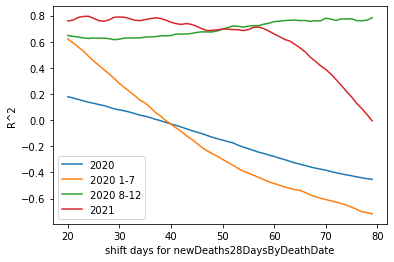

In [24]:
## calibrate time shift for deaths as these are delayed by about 30 days
# this is done by maximising the correlation (R^2) on the 2020 fraction

year1 = 2020
df2020 = filterByYearAndMonth(df, year1)
s, N2020, NMax2020 = shiftCalibrate(df2020)
print("year {y}: correlation max is {c} at N={n}".format(y=year1, c=NMax2020, n=N2020))
ax = s.plot()
    
## check also first half of 2020 only
df2020_1 = filterByYearAndMonth(df, 2020, 1,7)
s, N2020_1, NMax2020_1 = shiftCalibrate(df2020_1)
print("year {y}: correlation max is {c} at N={n}".format(y="2020 1-7", c=NMax2020_1, n=N2020_1))
ax = s.plot()

## check also second half of 2020 only
df2020_2 = filterByYearAndMonth(df, 2020, 8,12)
s, N2020_2, NMax2020_2 = shiftCalibrate(df2020_2)
print("year {y}: correlation max is {c} at N={n}".format(y="2020 8-12", c=NMax2020_2, n=N2020_2))
ax = s.plot()

year2 = 2021
df2021 = filterByYearAndMonth(df, year2)
s, N2021, NMax2021 = shiftCalibrate(df2021)
print("year {y}: correlation max is {c} at N={n}".format(y=year2, c=NMax2021, n=N2021))
ax = s.plot(xlabel='shift days for newDeaths28DaysByDeathDate', ylabel='R^2')

ax.legend([str(year1), str(year1)+" 1-7", str(year1)+" 8-12", str(year2)])

based on the analysis above, and on the standard "death recorded 28 days after testing positive" rule, we are going to timeshift at N=30 for all time slices
because of the shifting, we only consider slices of at least two months 

time plots and scatter plots with correlation scores (pearson R^2) for different time periods

## entire timeline

In [25]:
df1 = removeNullRecords(shiftAdmissionsBy(14, shiftDeathsBy(30, df)))

density plot -- distribution of cases


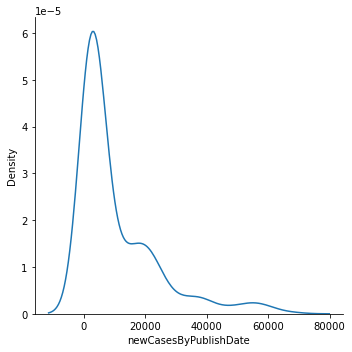

In [26]:
## distribution of new cases -- used to decide on a threshold for correlation analysis

print("density plot -- distribution of cases")
sns.displot(data=df1, x='newCasesByPublishDate', kind='kde', log_scale=False)

### based on density plot, zoom in 0-10000 cases

Pearson's correlations:
newCasesByPublishDate vs newAdmissions: 		0.60
newCasesByPublishDate vs newDeaths28DaysByDeathDate: 	0.22


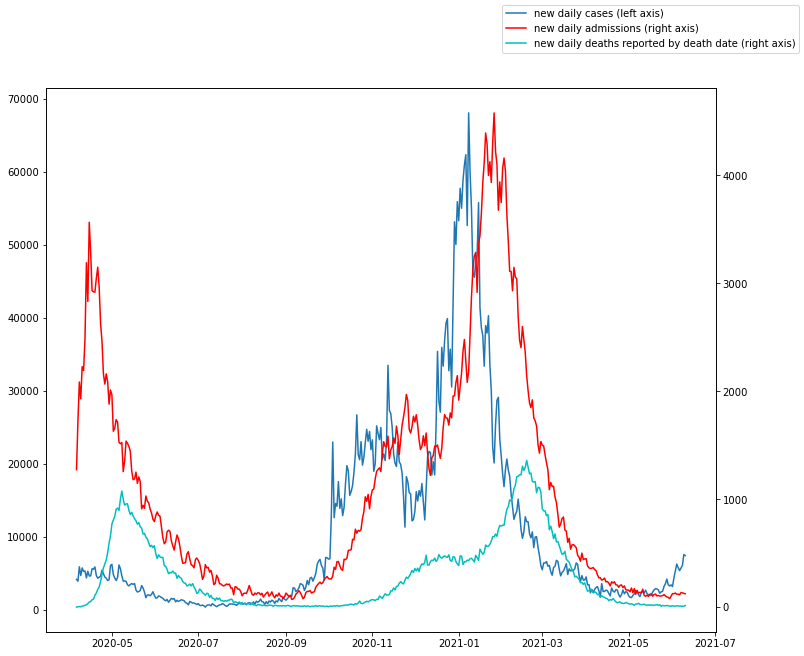

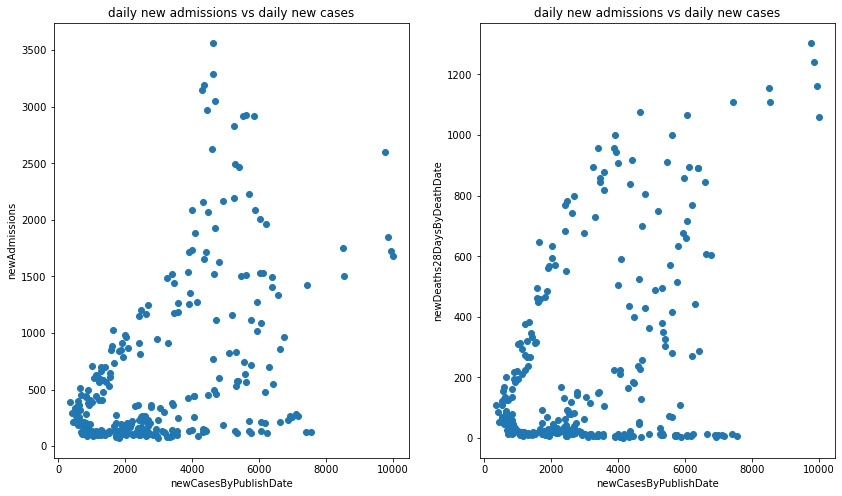

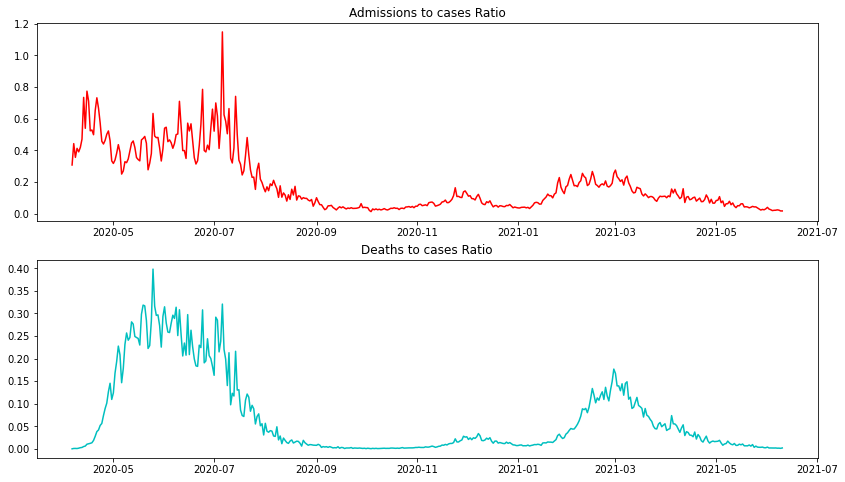

In [27]:
plotCasesVsAdmissionsVsDeaths(df1)

corrAndScatterPlots(df1, thr=10000)

plotRatios(df1)

In [28]:
summaryStats(df1)



** summary stats **
newCasesByPublishDate:
count      431.000000
mean     10538.983759
std      13275.450644
min        343.000000
25%       1943.000000
50%       4583.000000
75%      15946.500000
max      68053.000000
Name: newCasesByPublishDate, dtype: float64 

newAdmissions:
count     431.000000
mean     1073.828306
std      1072.553642
min        72.000000
25%       198.000000
50%       643.000000
75%      1621.000000
max      4578.000000
Name: newAdmissions, dtype: float64 

newDeaths28DaysByDeathDate:
count     431.000000
mean      296.236659
std       336.793650
min         0.000000
25%        24.000000
50%       142.000000
75%       464.000000
max      1359.000000
Name: newDeaths28DaysByDeathDate, dtype: float64 



## time: all of 2020

In [29]:
df1 = filterByYearAndMonth(df, 2020)
df1 = removeNullRecords(shiftAdmissionsBy(14, shiftDeathsBy(30, df1)))

df1.head()

,areaCode,areaName,areaType,date,newAdmissions,newCasesByPublishDate,newDeaths28DaysByDeathDate
161,K02000001,United Kingdom,overview,2020-12-31,2144.0,55892,399.0
162,K02000001,United Kingdom,overview,2020-12-30,2079.0,50023,423.0
163,K02000001,United Kingdom,overview,2020-12-29,1957.0,53135,464.0
164,K02000001,United Kingdom,overview,2020-12-28,1955.0,41385,467.0
165,K02000001,United Kingdom,overview,2020-12-27,1753.0,30501,423.0


density plot -- distribution of cases


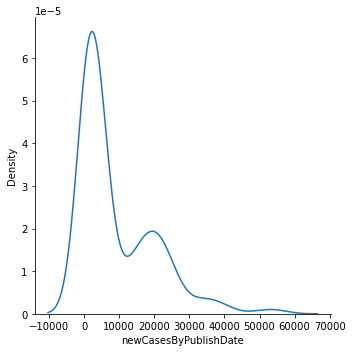

In [30]:
print("density plot -- distribution of cases")
sns.displot(data=df1, x='newCasesByPublishDate', kind='kde', log_scale=False)

Pearson's correlations:
newCasesByPublishDate vs newAdmissions: 		0.41
newCasesByPublishDate vs newDeaths28DaysByDeathDate: 	0.07


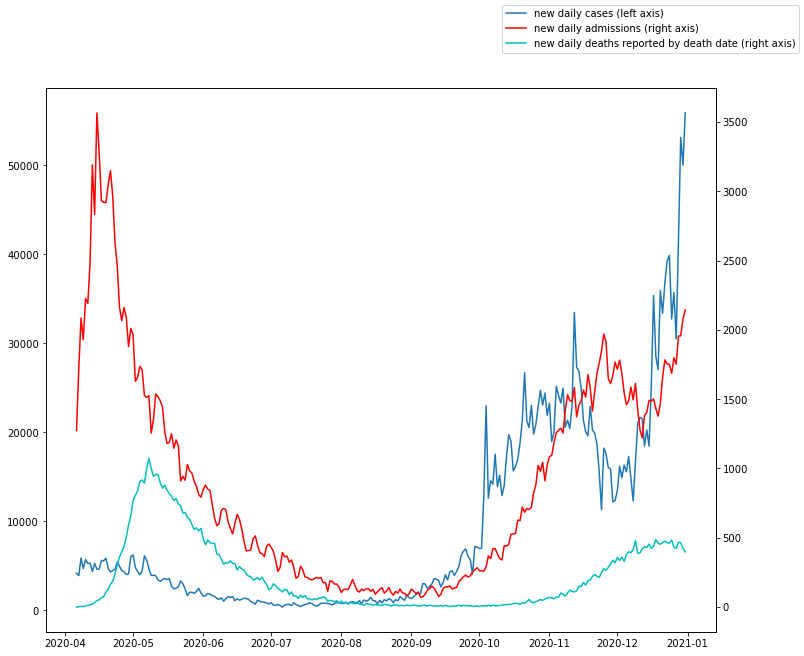

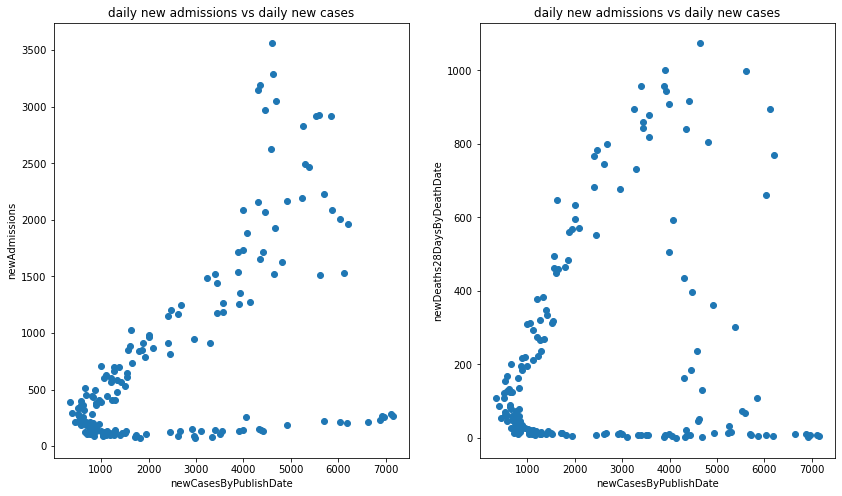

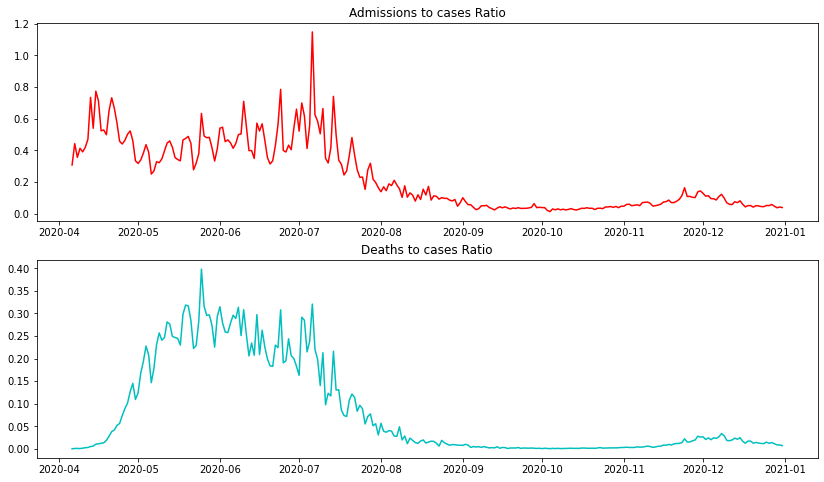

In [31]:
plotCasesVsAdmissionsVsDeaths(df1)

corrAndScatterPlots(df1, thr=10000)

plotRatios(df1)

In [32]:
summaryStats(df1)



** summary stats **
newCasesByPublishDate:
count      270.000000
mean      9152.048148
std      10838.441716
min        343.000000
25%       1189.250000
50%       3993.500000
75%      16266.250000
max      55892.000000
Name: newCasesByPublishDate, dtype: float64 

newAdmissions:
count     270.000000
mean      921.681481
std       785.240495
min        72.000000
25%       213.250000
50%       700.000000
75%      1500.250000
max      3565.000000
Name: newAdmissions, dtype: float64 

newDeaths28DaysByDeathDate:
count     270.000000
mean      225.125926
std       262.331877
min         0.000000
25%        18.500000
50%       102.500000
75%       387.500000
max      1075.000000
Name: newDeaths28DaysByDeathDate, dtype: float64 



### plot second half of 2020

In [33]:
df1 = filterByYearAndMonth(df, 2020, 8,12)
df1 = removeNullRecords(shiftAdmissionsBy(14, shiftDeathsBy(30, df1)))

density plot -- distribution of cases


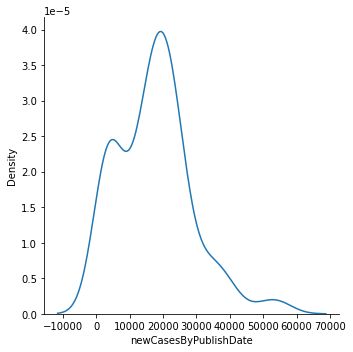

In [34]:
print("density plot -- distribution of cases")
sns.displot(data=df1, x='newCasesByPublishDate', kind='kde', log_scale=False)

Pearson's correlations:
newCasesByPublishDate vs newAdmissions: 		0.75
newCasesByPublishDate vs newDeaths28DaysByDeathDate: 	0.62


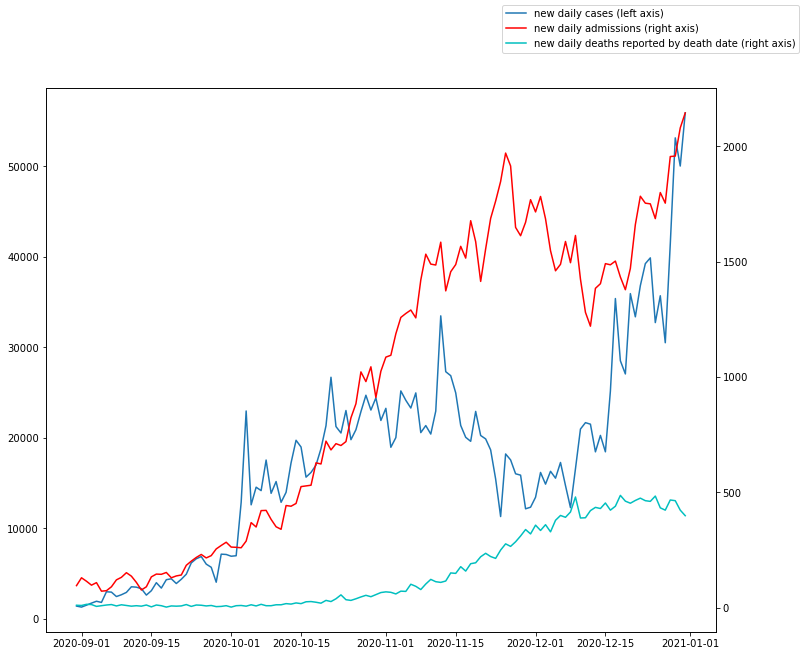

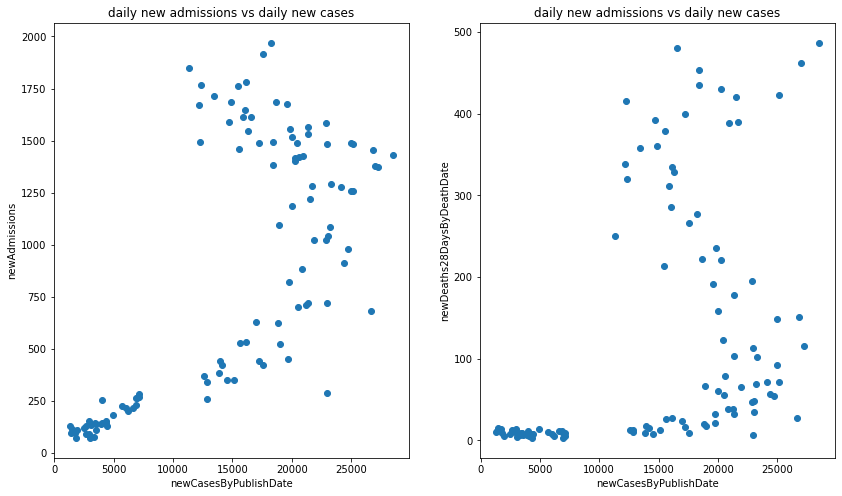

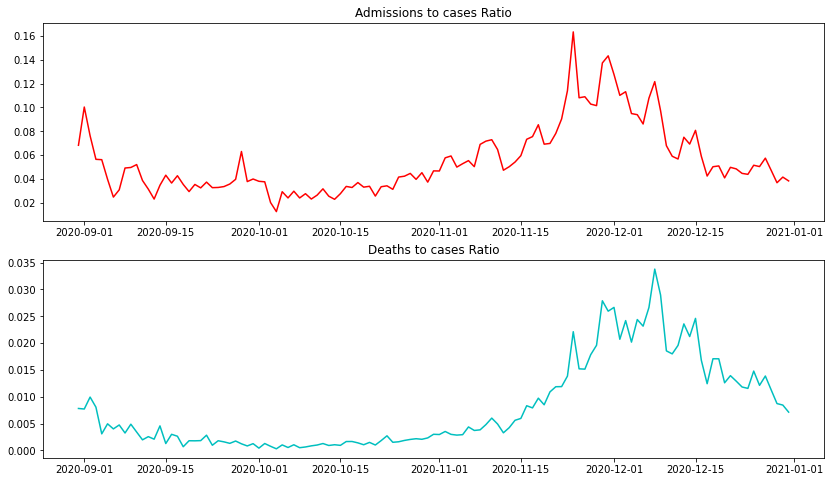

In [35]:
plotCasesVsAdmissionsVsDeaths(df1)

corrAndScatterPlots(df1, thr=30000)

plotRatios(df1)

In [36]:
summaryStats(df1)



** summary stats **
newCasesByPublishDate:
count      123.000000
mean     17525.528455
std      11211.001732
min       1295.000000
25%       7038.000000
50%      17555.000000
75%      22955.500000
max      55892.000000
Name: newCasesByPublishDate, dtype: float64 

newAdmissions:
count     123.000000
mean      962.715447
std       654.837090
min        72.000000
25%       262.500000
50%      1044.000000
75%      1539.500000
max      2144.000000
Name: newAdmissions, dtype: float64 

newDeaths28DaysByDeathDate:
count    123.000000
mean     157.991870
std      174.771068
min        3.000000
25%       12.000000
50%       60.000000
75%      332.000000
max      487.000000
Name: newDeaths28DaysByDeathDate, dtype: float64 



### plot all of 2021

In [37]:
df1 = filterByYearAndMonth(df, 2021)
df1 = removeNullRecords(shiftAdmissionsBy(14, shiftDeathsBy(30, df1)))

density plot -- distribution of cases


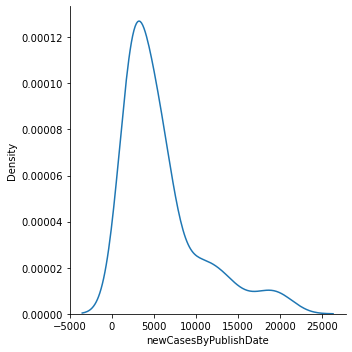

In [38]:
print("density plot -- distribution of cases")
sns.displot(data=df1, x='newCasesByPublishDate', kind='kde', log_scale=False)

Pearson's correlations:
newCasesByPublishDate vs newAdmissions: 		0.95
newCasesByPublishDate vs newDeaths28DaysByDeathDate: 	0.77


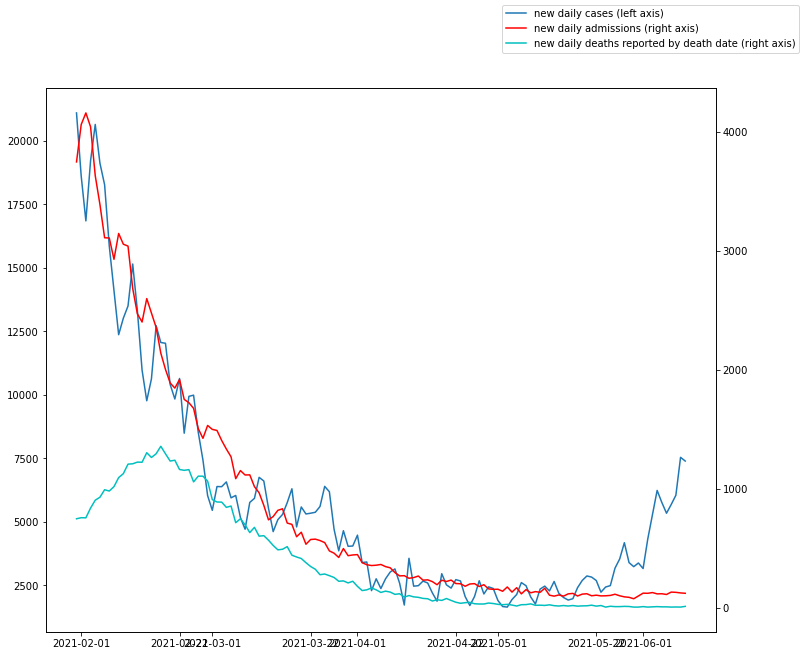

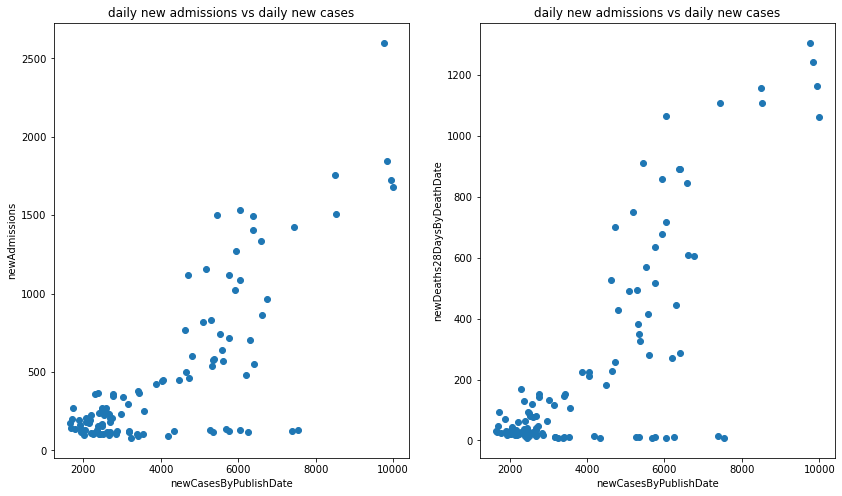

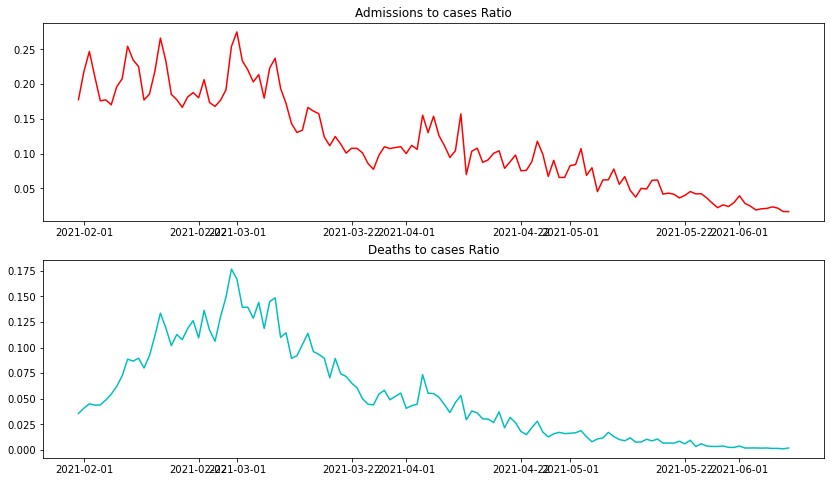

In [39]:
plotCasesVsAdmissionsVsDeaths(df1)

corrAndScatterPlots(df1, thr=10000)

plotRatios(df1)

In [40]:
summaryStats(df1)



** summary stats **
newCasesByPublishDate:
count      131.000000
mean      5831.564885
std       4574.724422
min       1649.000000
25%       2508.500000
50%       4479.000000
75%       6485.000000
max      21088.000000
Name: newCasesByPublishDate, dtype: float64 

newAdmissions:
count     131.000000
mean      873.267176
std      1057.420336
min        78.000000
25%       134.000000
50%       357.000000
75%      1303.500000
max      4160.000000
Name: newAdmissions, dtype: float64 

newDeaths28DaysByDeathDate:
count     131.000000
mean      391.465649
std       446.310297
min         8.000000
25%        24.500000
50%       142.000000
75%       754.000000
max      1359.000000
Name: newDeaths28DaysByDeathDate, dtype: float64 



### zoom in 1-4 2021

In [42]:
df1 = filterByYearAndMonth(df, 2021, 1,4)
df1 = removeNullRecords(shiftAdmissionsBy(14, shiftDeathsBy(30, df1)))

density plot -- distribution of cases


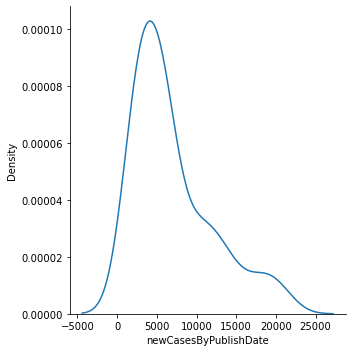

In [43]:
print("density plot -- distribution of cases")
sns.displot(data=df1, x='newCasesByPublishDate', kind='kde', log_scale=False)

Pearson's correlations:
newCasesByPublishDate vs newAdmissions: 		0.97
newCasesByPublishDate vs newDeaths28DaysByDeathDate: 	0.75


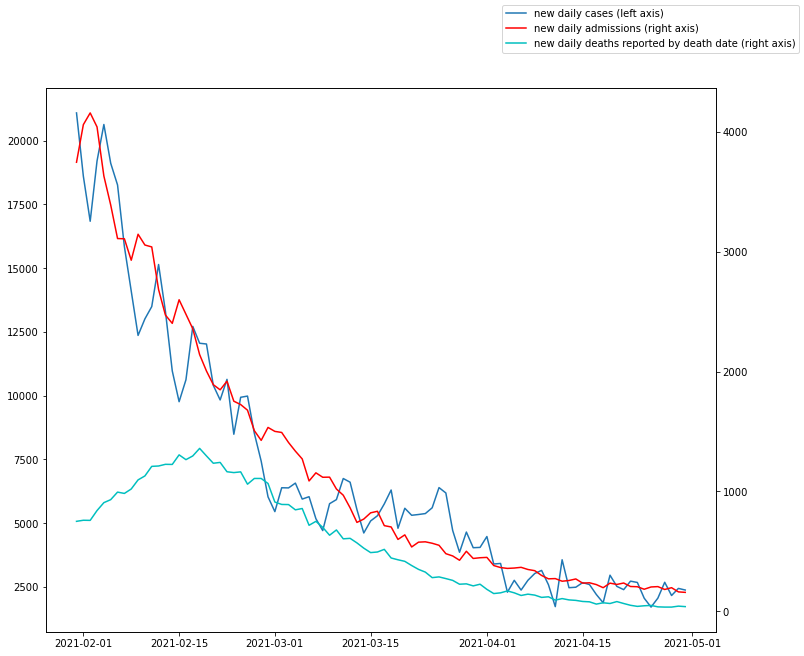

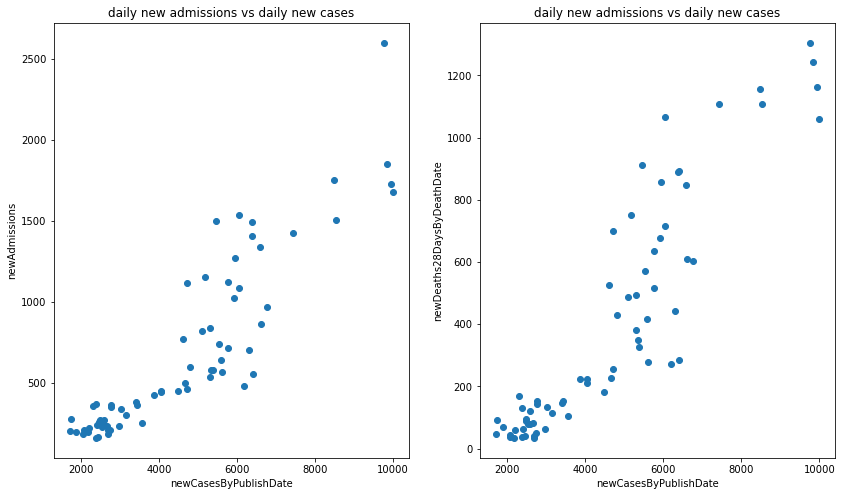

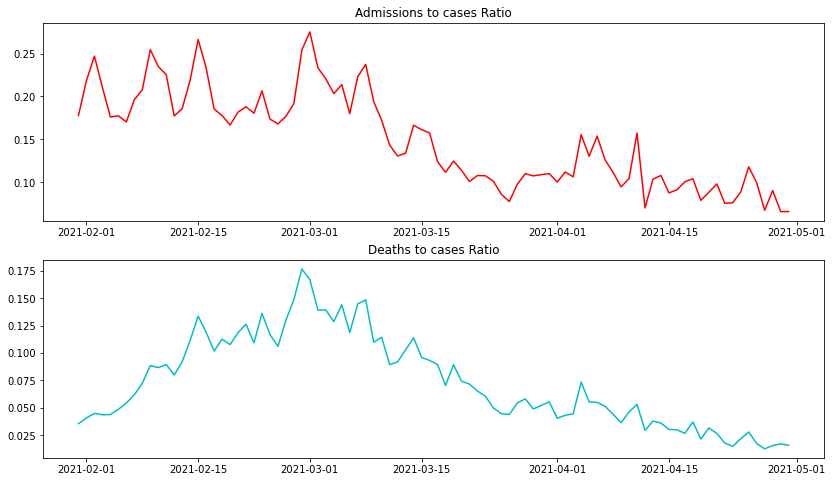

In [44]:
plotCasesVsAdmissionsVsDeaths(df1)

corrAndScatterPlots(df1, thr=10000)

plotRatios(df1)

In [45]:
summaryStats(df1)



** summary stats **
newCasesByPublishDate:
count       90.000000
mean      6993.633333
std       5005.827172
min       1712.000000
25%       2813.000000
50%       5494.500000
75%       9912.000000
max      21088.000000
Name: newCasesByPublishDate, dtype: float64 

newAdmissions:
count      90.000000
mean     1215.866667
std      1119.724135
min       157.000000
25%       340.500000
50%       727.500000
75%      1824.250000
max      4160.000000
Name: newAdmissions, dtype: float64 

newDeaths28DaysByDeathDate:
count      90.000000
mean      561.788889
std       444.069776
min        34.000000
25%       131.750000
50%       491.500000
75%       970.000000
max      1359.000000
Name: newDeaths28DaysByDeathDate, dtype: float64 



### zoom in 3-6 2021 only

In [46]:
df1 = filterByYearAndMonth(df, 2021, 3,6)
df1 = removeNullRecords(shiftAdmissionsBy(14, shiftDeathsBy(30, df1)))

density plot -- distribution of cases


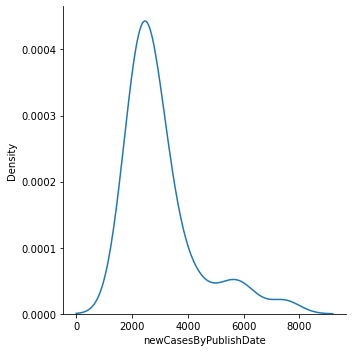

In [47]:
print("density plot -- distribution of cases")
sns.displot(data=df1, x='newCasesByPublishDate', kind='kde', log_scale=False)

Pearson's correlations:
newCasesByPublishDate vs newAdmissions: 		-0.08
newCasesByPublishDate vs newDeaths28DaysByDeathDate: 	-0.11


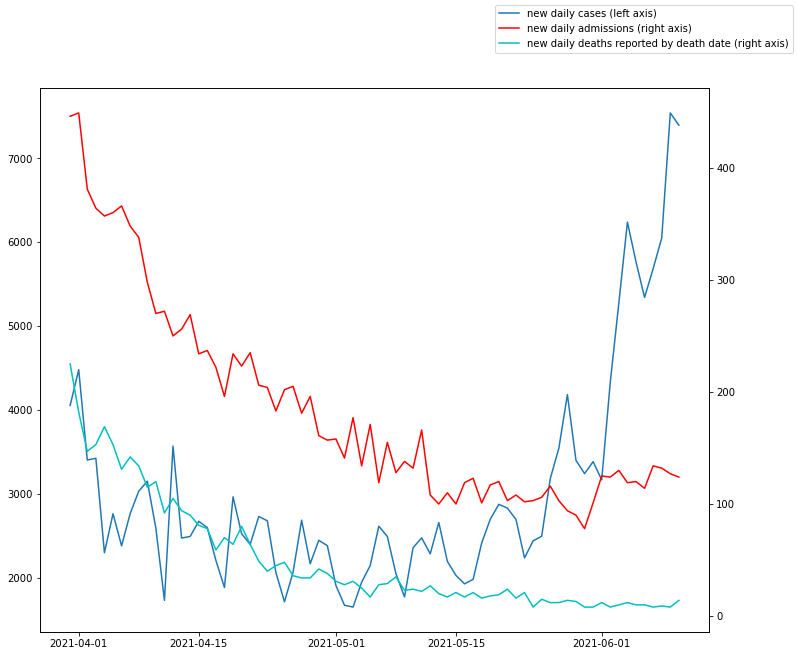

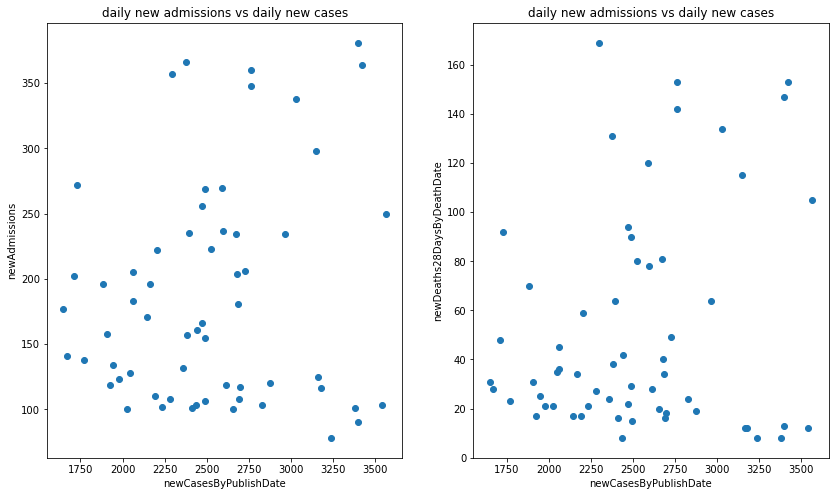

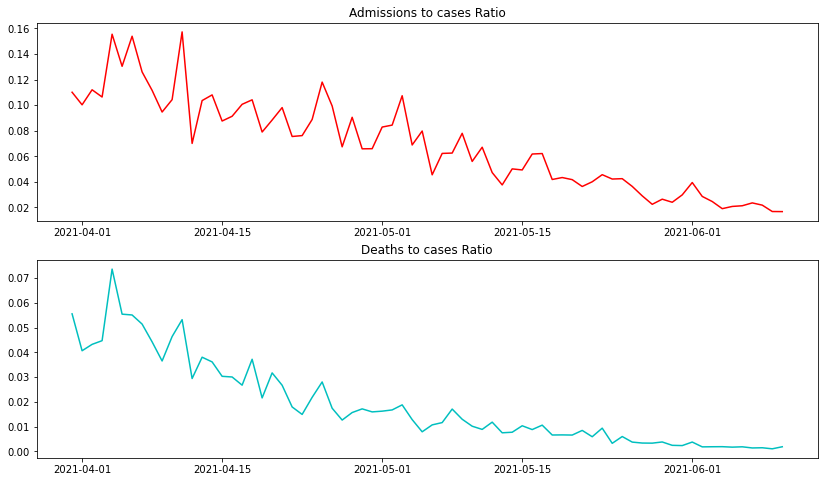

In [48]:
plotCasesVsAdmissionsVsDeaths(df1)
corrAndScatterPlots(df1, thr=4000)
plotRatios(df1)

In [ ]:
summaryStats(df1)